### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [496]:
!pip install numdifftools

In [497]:
# import numdifftools as nd
# H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
# sigma_laplace = np.linalg.inv(H)**0.5

In [498]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats

# Solutions

### 1. Read in data & Compute heteroscedastic $\mu$  and $\sigma$ 

In [499]:
# Load the dataset 
data = np.load('/Users/jarretsm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw3_data_1.npy') 

# Extract data
x = data[:, 0] #first column is measurements
sigma = data[:, 1] #Second column is uncertainties

#Compute sample mean and standard error for heteroscedastic gaussian
Het_mu = (np.sum(x/ (sigma**2))) / (np.sum(1/ (sigma**2 )) )
Het_sigma = np.sum ( 1 / (sigma**2))**(-1/2)

OGMean = np.mean(x)
OGStd = np.std(x)
print("Original Mean:", OGMean)
print("Original Sigma:", OGStd)
print("Heteroscedastic Mean:", Het_mu)
print("Heteroscedastic Sigma:", Het_sigma)


Original Mean: 3.937547512109005
Original Sigma: 1.1507206049948653
Heteroscedastic Mean: 3.9179920346060557
Heteroscedastic Sigma: 0.09481084100510954


SRT: Great!

### 2. Write a ln-likelihood function & Find the best-fit mean


<span style="color:blue">


### Reminder summary on Likelihood and log likelihood:

#### Probability:
When we know the distribution and when we want information about the data. We take a "chunk" underneath that curve defined by some mu and sigma if it is Gaussian, and the probability of finding some value in your data is the area in the region under the curve. For example, the probability we weight a mouse above 34 grams, given the distribution has a mean of 32 and deviation of 2.5 is 29%. That notation is P(Data|Distribution) 

#### Liklihood:
The reverse, when we know the data but want information on the distribution. Liklihood instead asks, the liklihood of this distriburion with some mu and sigma, given our data is blah. For example, the probability our distribution has a mean of 32 and deviation of 2.5 given we weigh a mouse of 34 granms is 12%. That notation is P(Distribution|Data) 

#### Log liklihood: 
It is easier to take the derivative of a function that includes e^x as a log in this case because both the derivative of the function and derivative of the log of a function give back zero if that value is at a maximum. Doing this allows us to solve for the lambda that is the most likley.

Another reason we use log, when we are looking for the liklihood i.e. L(theta) = P(x1|theta) * P(x2|theta) * P(x3|theta)... when taking all these products it leads to arithmetic underflow. Say the first term is some probability between 0 and 1 like 0.83, the second probability term is 0.74 and so on. We eventually get to values getting closer to zero and computers might struggle doing this. So we want to convert it to a summation by changing to log on both sides. 

In [500]:
# Write a ln-likelihood function for heteroscedastic Gaussian data
# Recall: LnL is the likelihood that the model is good given our data. For the Gaussian case, we compute the z-score for each data point
def Ln_Likelihood(mu, x, sigma):    
    Z = (x - mu) / sigma
    LnL = -0.5 * np.sum(Z**2)  # Calculate LnL (i.e. X^2 for Gaussian)
    return - LnL

# Create a fitting algorithm to find the best-fit mean.
# Note minimizing LnL maximizes the likelihood, and scipy optimizers are set up to minimize functions.
Maximize_LnL = optimize.minimize(Ln_Likelihood, x0=Het_mu, args=(x, sigma))

# Extract the best-fit mean 
best_fit_mu = Maximize_LnL.x[0]

print("Best-fit Mean from maximizing the LnL is: %.5f" % best_fit_mu) 

Best-fit Mean from maximizing the LnL is: 3.91799


SRT: Excellent!

### 3. Compute the Fisher uncertainty estimate on the mean.

In [501]:
#Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.
# Calculate the second derivative of the log-likelihood function numerically around best_fit_mu
delta_mu = 1e-5  # Small perturbation for numerical derivative
UpperMu = Ln_Likelihood(best_fit_mu + delta_mu, x, sigma)
LowerMu = Ln_Likelihood(best_fit_mu - delta_mu, x, sigma)
LnLMu = Ln_Likelihood(best_fit_mu, x, sigma)

SecondDeriv = (UpperMu - 2 * LnLMu + LowerMu) / (delta_mu ** 2)

# Calculate the Fisher uncertainty estimate for the mean
sigma_mu = np.sqrt(1 / SecondDeriv)

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 0.095


SRT: Hmm, this works! You must let me know at some point what the mathematical justification for this is. But it's clear that it's justified and works.

### 4. Write bootstrap method


In [502]:
# Number of bootstrap samples
num_bootstrap_samples = 1000  # You can adjust this number

# Store each bootstrap sample's results
BootstrapMu = np.zeros((num_bootstrap_samples, len(x)))
BootstrapSigma = np.zeros((num_bootstrap_samples, len(x)))

# Seed the random number generator
np.random.seed(42)

# Perform bootstrap resampling
for i in range(num_bootstrap_samples):
    # Generate random indices with replacement
    resample_indices = np.random.choice(len(x), size=len(x), replace=True)

    # Create the resampled dataset
    BootstrapMu[i] = x[resample_indices]
    BootstrapSigma[i]=sigma[resample_indices]
    
print, BootstrapSigma.shape

(<function print>, (1000, 100))

SRT: Very good.

### 5. Find Best Fit mean with Bootstrap data 

In [503]:
import numpy as np
from scipy import optimize

# Ln-Likelihood function for bootstrap data
def Ln_Likelihood_Boot(mu, Bootstrap_Mu, Bootstrap_Sigma):
    Z = (Bootstrap_Mu - mu) / Bootstrap_Sigma
    LnLBoot = -0.5 * np.sum(Z**2) 
    return -LnLBoot  # Return negative LnL for minimization

# Array to store best-fit means from bootstrap data
bootstrap_best_fit_mus = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    
    Bootstrap_Mu = BootstrapMu[i]
    Bootstrap_Sigma = BootstrapSigma[i]

    # Find best-fit means for this bootstrap data
    Maximize_LnLBoot = optimize.minimize(Ln_Likelihood_Boot, x0=Het_mu, args=(Bootstrap_Mu, Bootstrap_Sigma))
    
    # Store the best-fit mean
    bootstrap_best_fit_mus[i] = Maximize_LnLBoot.x[0]

print("Best-fit Mean from maximizing the Bootstrap LnL for the last sample is: %.5f" % bootstrap_best_fit_mus[-1])

Best-fit Mean from maximizing the Bootstrap LnL for the last sample is: 3.94833


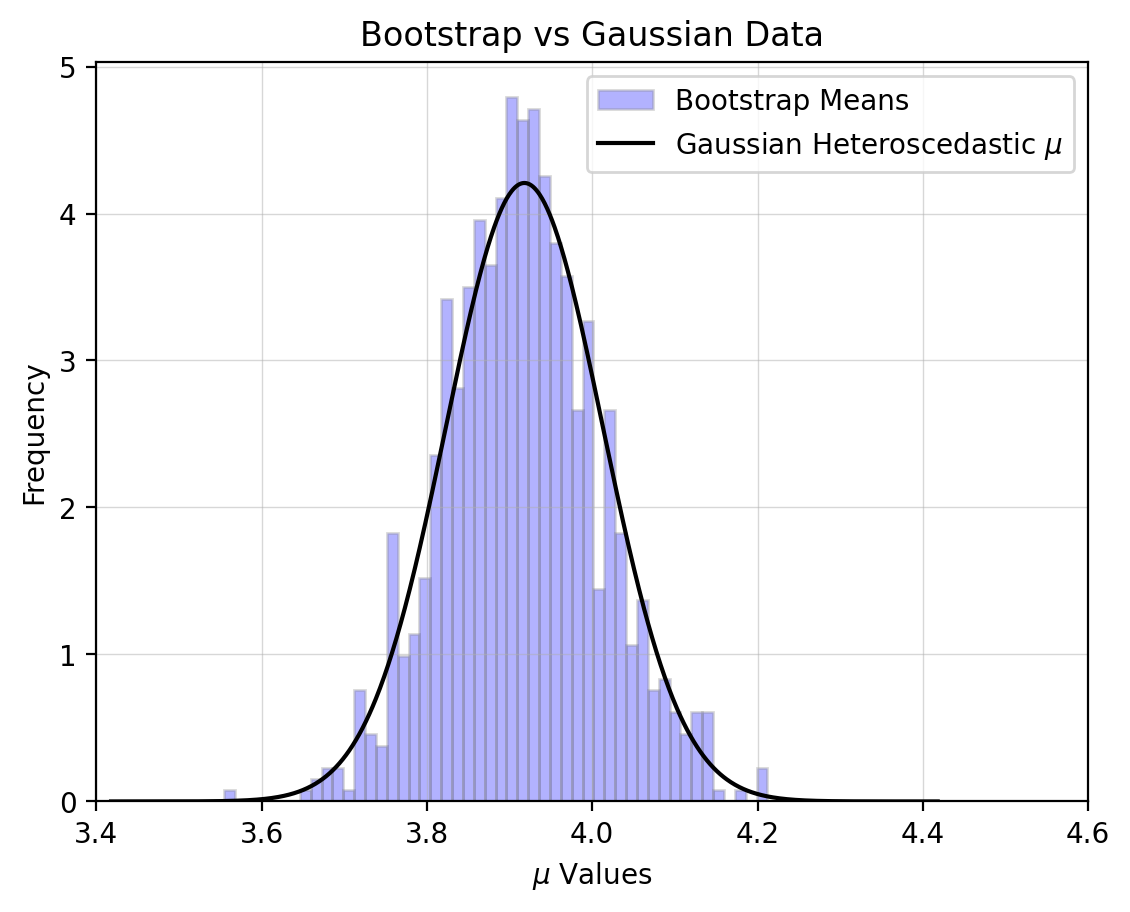

In [504]:
#Plot a normalized Bootstrap histogram and Hetero Gaussian

#Bootstrap Data
plt.hist(bootstrap_best_fit_mus, density=True, color='b', alpha=0.3, bins=50, edgecolor='grey', label='Bootstrap Means');

#Gaussian Data
xgrid = np.linspace(Het_mu-(1/2),Het_mu+(1/2),1000)
dist = scipy.stats.norm(Het_mu,Het_sigma)
plt.plot(xgrid, dist.pdf(xgrid), c='black', label='Gaussian Heteroscedastic $\mu$')

plt.legend()
plt.title("Bootstrap vs Gaussian Data")
plt.ylabel("Frequency")
plt.xlabel("$\mu$ Values");
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.xlim(3.4,4.6);

<span style="color:darkblue">


#### In creating a histogram for the best fit mu values pulled from the bootstrapped data, and comparing this plot to the Gaussian created from the heteroscedastic mean and sigma, we can see that the Gaussian fits the histogram very well. The heteroscedastic mean is about 3.9 and the spread of the data is about 0.1. This is because when we increase the number of times we calculate the mean from a sample of our distribution, this result will begin to approach a Gaussian fit. If we had performed 10,000 calculations, we would see the histogram match the gaussian very closely because of the Central Limit theorem. 


SRT: terrific!

#### 6 Write a ln-likelihood for a Laplace distribution 

<span style="color:blue">



##### The probability density function (PDF) for a Laplace distribution is below where delta is the equivalent of sigma with a Gaussian

$$
f(x|\mu, \Delta) = \frac{1}{2\Delta} \exp\left(-\frac{|x - \mu|}{\Delta}\right)
$$


When we take the log-likelihood it becomes:

$$
\ln L = \sum_{i=1}^{N} \ln \left( \frac{1}{2\Delta} \exp\left(-\frac{|x - \mu|}{\Delta}\right) \right)
$$

This simplifies to:

$$
\ln L = -\sum_{i=1}^{N} \frac{|x - \mu|}{\Delta}
$$


In [505]:
# Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. 


#Definition which returns a scalar for minimization function
def Ln_Likelihood_Lap(mu, x, delta):  
    N = len(x)
    normalization = N * np.log(1 / (2 * delta))
    LnL = np.sum( normalization * (np.abs(x - mu) / delta))  
    return - LnL

#Fit simultaneously for the Laplace mu and delta parameter
Maximize_LnL_Lap = optimize.minimize(Ln_Likelihood_Lap, x0=Het_mu, args=(x, sigma))
best_fit_mu_Lap = Maximize_LnL_Lap.x[0]

print("Best-fit Mean from maximizing the Laplacian LnL is: %.5f" % best_fit_mu_Lap) 

Best-fit Mean from maximizing the Laplacian LnL is: 4.10136


SRT: Good. And the delta? -1 point

### 7. Compute the AIC values

The AIC stands for Akaike Information Criterion (AIC) and is a way to compare different models by balancing how well they fit the data vs complex they are. Values with more parameters (i.e. k) are less favored called the Occam Penalty. The AIC can be calculated using this equation:

$$
AIC = 2k - 2\ln(L)
$$

When we are dealing with a smaller sample size, we have to include a correction term. So we use this equation instead:


$$
AIC with Correction = AIC + (\frac{2k(k+1)}{n-k-1})
$$

The equation from class notes (one I will use) is: 

$$
AIC_m =-2\ln(L^{\text{Max}}(M)) + 2k + \frac{2k(k+1)}{n-k-1}\
$$



In [506]:
#Definition which returns an array for AIC
def Ln_Likelihood_Lap(mu, x, delta):  
    N = len(x)
    normalization = -N * np.log(1 / (2 * delta))
    LnL = np.sum((np.abs(x - mu) / delta))  
    return normalization - LnL

In [507]:
#Compute the AIC values for heteroscedastic Gaussian
k=2
Correction= (2*k *(k+1) )/ (len(x)-k-1)
Max_LnLGauss = 2* Maximize_LnL.fun
AIC_Gauss =  2* Max_LnLGauss + (2*k) + Correction

#Compute the AIC values for Laplacian model
Maximize_Lap=np.max(Ln_Likelihood_Lap (Het_mu, x, sigma))
Max_LnLLap = 2*Maximize_Lap
AIC_Lap =  2* Max_LnLLap + (2*k) + Correction

print(f"AIC for the Gaussian model: {AIC_Gauss}")
print(f"AIC for the Laplacian model: {AIC_Lap}")

AIC for the Gaussian model: 176.77389272607377
AIC for the Laplacian model: 248.46913914772873


<span style="color:darkblue">


#### The model that is favored by the data is the Gaussian model which gives a lower AIC score. Since both models use the same number of parameters of k = 2 for the mean and the sigma, the Gaussian is the better fit because it has a higher Log Likelihood (-ln(L)) comapred to the Laplacian distribution

SRT: Nice

### 8. Laplacian Bootstrap & Corner Plots


In [508]:
import numpy as np
from scipy import optimize

# Ln-Likelihood function for bootstrap data
def Ln_Likelihood_Boot(mu, Bootstrap_Mu, Bootstrap_Sigma):
    N = len(x)
    normalization = N * np.log(1 / (2 * Bootstrap_Sigma))
    LnLBoot = np.sum( normalization * (np.abs(Bootstrap_Mu - mu) / Bootstrap_Sigma))
    return -LnLBoot  # Return negative LnL for minimization

# Array to store best-fit means from bootstrap data
bootstrap_best_fit_deltas_L = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    
    Bootstrap_Mu = BootstrapMu[i]

    # Find best-fit means for this bootstrap data
    Maximize_LnLBoot = optimize.minimize(Ln_Likelihood_Boot, x0=Het_mu, args=(Bootstrap_Mu, Bootstrap_Sigma))
    
    # Store the best-fit mean
    bootstrap_best_fit_mus_L[i] = Maximize_LnLBoot.x[0]
   

print("Best-fit Mean from maximizing the Bootstrap LnL for the last sample is: %.5f" % bootstrap_best_fit_mus_L[-1])

Best-fit Mean from maximizing the Bootstrap LnL for the last sample is: 4.07784


In [509]:
#Identify index of best mu data to align with best sigma data for corner plot 
indices = [np.argmin(np.abs(BootstrapMu[i] - bootstrap_best_fit_mus_L[i])) for i in range(num_bootstrap_samples)]
selected_deltas_L = np.array([BootstrapSigma[i, idx] for i, idx in enumerate(indices)])

SRT: I'm confused. Why didn't you store the fitted Delta parameter as well? The `.x` output of `optimize` is a 2D vector of the best-fit `mu` and `Delta`. You need both of those to make the corner plot. It doesn't make any sense to combine the best-fitted `mu` from the Laplacian with what appears to be bootstrapped data uncertainty values. -3 points.

/var/folders/5c/kkcpl36x6c78d36n8pktxwjm0000gr/T/ipykernel_35579/996182731.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


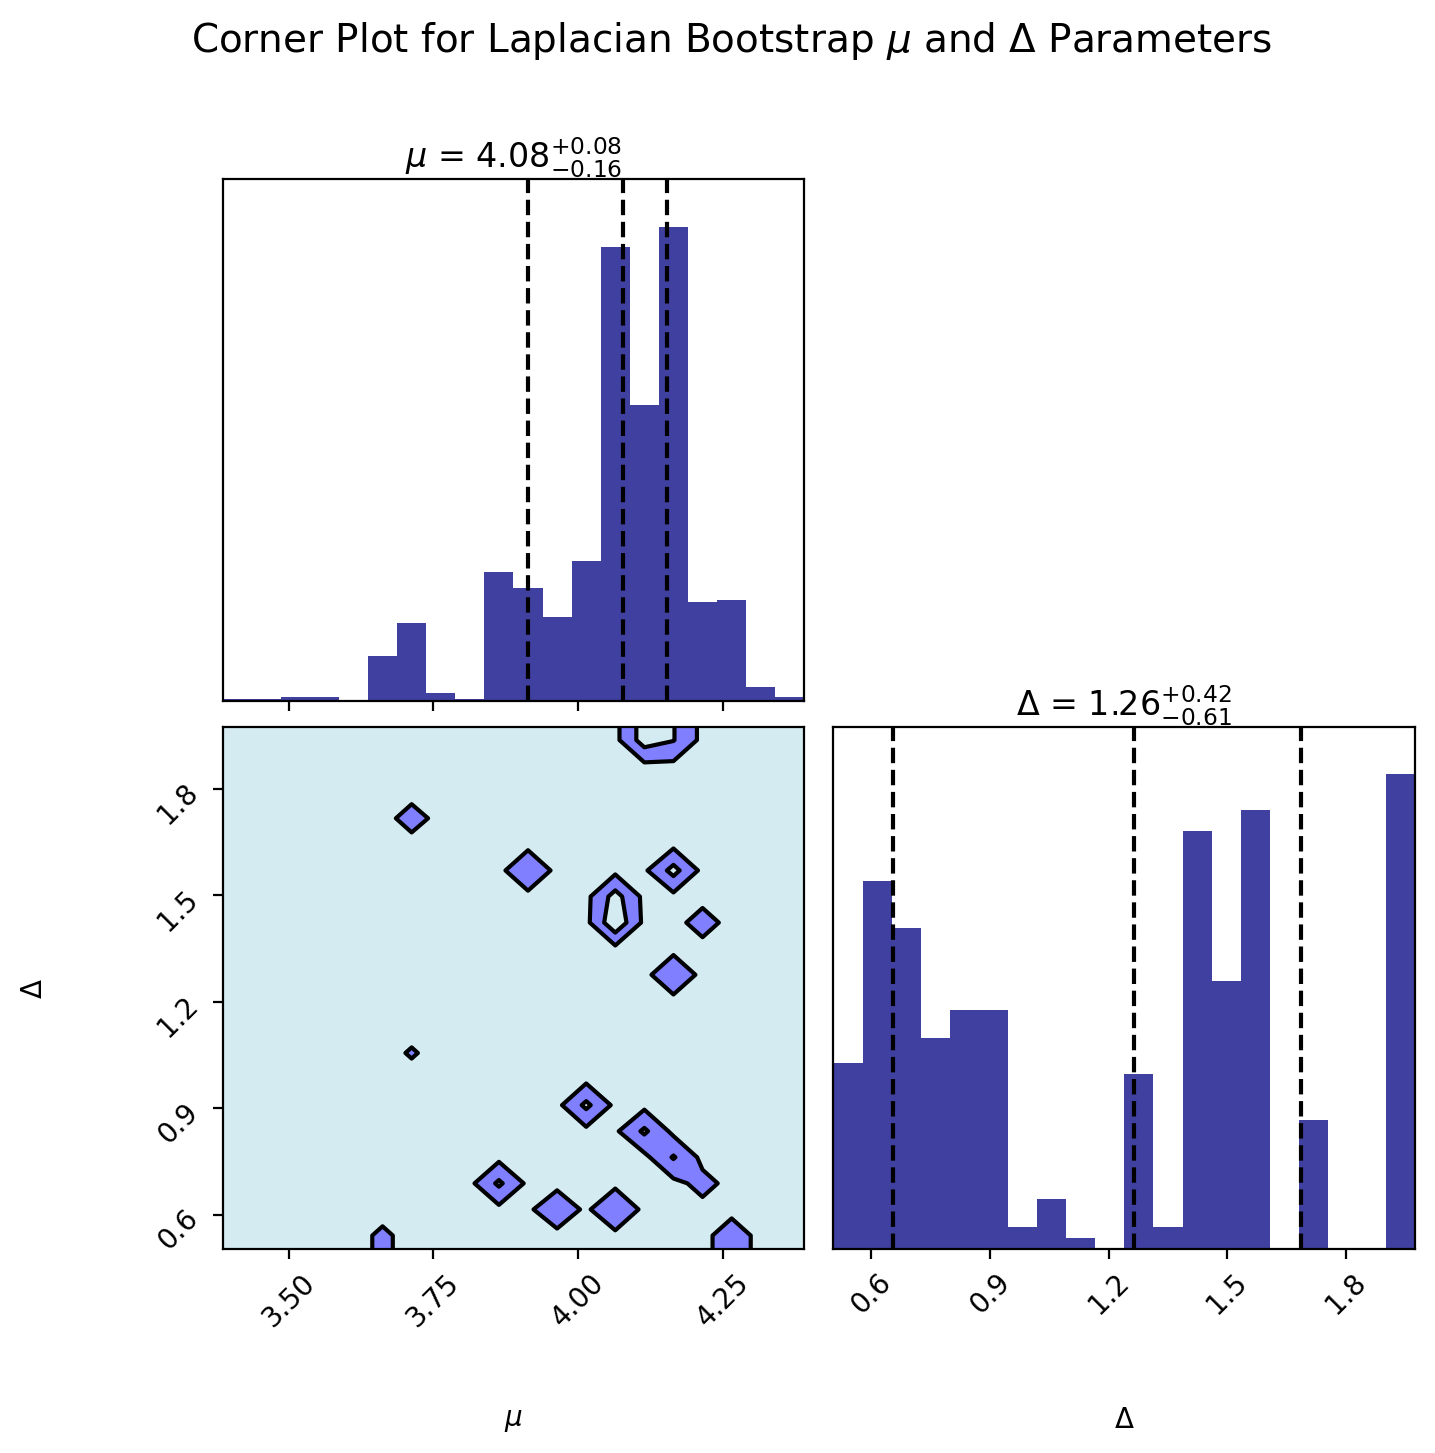

In [510]:
import corner

#Put together mu and sigma data 
data=np.array([bootstrap_best_fit_mus_L,selected_deltas_L ])
data=np.transpose(data)

# Create the corner plot 
fig = corner.corner(data, labels=[r'$\mu$', r'$\Delta$'], quantiles=[0.16, 0.5, 0.84],levels=[0.68, 0.95],
                    show_titles=True, title_fmt='.2f', plot_datapoints=False, plot_density=False, fill_contours=True,  # Fill contours to look nicer
                    contour_kwargs={'colors': 'black'},contourf_kwargs={'colors': ['lightblue', 'blue'], 'alpha': 0.5}, 
                    hist_kwargs={'color': 'navy', 'histtype': 'stepfilled', 'alpha': 0.75},
                    title_kwargs={'fontsize': 12, 'verticalalignment': 'top'})  # Titles on 1D marginal plots

# Fix space at the top
fig.subplots_adjust(top=0.85)
fig.suptitle(r"Corner Plot for Laplacian Bootstrap $\mu$ and $\Delta$ Parameters", fontsize=14, y=0.95)


# Set the overall figure size
fig.set_size_inches(8, 8)  

# Display the plot
fig.show()

SRT: Some obvious problem here which should be commented upon. The fitted `mu` values are fine though. If you had kept the `Delta` values from the fit then this would've been perfect. -1 point

### 9. Laplacian Fisher Estimate 

In [511]:
# #Compute the Hessian matrix
# import numdifftools as nd

import numpy as np
import numdifftools as nd

# Modified function for Hessian computation
def LnL_Boot_For_Hessian(params, Bootstrap_Mu, Bootstrap_Sigma):
    mu, delta = params  
    original_likelihood = Ln_Likelihood_Boot(mu, Bootstrap_Mu, Bootstrap_Sigma)
    Norm = Het_mu / np.min(delta)  
    return original_likelihood + Norm

# Best-fit parameters (mu and an initial guess for delta)
best_fit_params = np.array([Het_mu, Het_sigma])

# Compute the Hessian matrix at the best-fit parameters using the modified function
hessian = nd.Hessian(lambda params: LnL_Boot_For_Hessian(params, bootstrap_best_fit_mus_L, selected_deltas_L))(best_fit_params)

print("Hessian matrix at best-fit parameters:")
print(hessian)

Hessian matrix at best-fit parameters:
[[ 1.77690848e+05  0.00000000e+00]
 [ 0.00000000e+00 -1.44648239e+00]]


In [512]:
#Invert the matrix, and take the square root. 
#The diagonal entries will then be the Fisher uncertainties 

# Invert the Hessian matrix
inverted_hessian = np.abs(np.linalg.inv(hessian))

#Square root of the inverted Hessian matrix
sqrt_inverted_hessian = np.sqrt(inverted_hessian)


Mu_Uncertainty = sqrt_inverted_hessian[0, 0]
Delta_Uncertainty = sqrt_inverted_hessian[1, 1]
print(f"The first element in the matrix is the uncertainty for μ and is ({Mu_Uncertainty:.5f})")
print(f"The last element in the matrix is the uncertainty for Δ and is ({Delta_Uncertainty:.5f})")

The first element in the matrix is the uncertainty for μ and is (0.00237)
The last element in the matrix is the uncertainty for Δ and is (0.83146)


<span style="color:darkblue">


#### Given that the diagonal entries are the Fisher uncertaines, the Fischer uncertainty for mu is 0.002 and I can see that the mu uncertainty from the corner plot is considerably larger with a range of +0.08 to -0.016. For the Fischer delta uncertainly I got a value of .83, which is closer to the range of delta in the corner plots which is from +.42 to -.61, however the fischer value is larger. So the fischer matrix in this case has underestimated the uncertainty for mu and has overestimated the uncertaintly for delta. Though I am unsure about the calculation of the Fischer mu, I will make a general statement on what those values should be and why. 
#### I expect the Fisher matrix values to estimate the lower bound of the standard deviation for mu and sigma, and in this case return very close uncertainties to the corner plots because the corner plots used the bootstrapped best fit values for both sigma and mu, and when using the best fit values since we conducted 1000 iterations, they will approach the actual values of our data. So I can use the corner plot uncertaines to make an assumption about the general population uncertaintes from the full data set. 

SRT: Good commentary here, Shaniya. In general you can trust bootstrapped distributions more to derive uncertainty estimates rather than the approximate Fisher matrix method.

But the setup for the Hessian calculation was wrong in several places. It should have been the best-fit Laplace mu and Laplace delta passed to the Hessian calculation, and not anything derived from bootstrapping or previous Gaussian calculations. -3 points.

Try the followign code cells.

In [ ]:
def lnlaplace(mu, delta, x):
    return np.sum(scipy.stats.laplace.logpdf(x, loc=mu, 
                                             scale=delta))

f_lnlaplace = lambda beta: -lnlaplace(beta[0], beta[1], x)

# compute the maximum likelihood 
beta0 = (1.0, 0.5) # initial guess for a and b
beta_laplace = optimize.fmin(f_lnlaplace, beta0)
print(beta_laplace)

In [ ]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5
print(sigma_laplace)